In [15]:
# !python tools/predict.py --config configs/segmenter/segmenter_rural2.yml --model_path ../output/segmenter_rural2/best_model/model.pdparams  --image_path ../photo/1167.png --save_dir ../output/test


### 🧪 项目简介：遥感图像多类分割（基于 PP-LiteSeg）

本项目基于 **PaddleSeg 提供的 PP-LiteSeg 模型**，用于遥感图像的语义分割任务。数据中包含多种地物标签，模型可输出多类别的像素级分割结果。PPLiteseg: Road Segment, Segmenter: multiple Segment

#### 📌 多分类标签说明：

| 类别编号 | 类别名称（英文） | 类别名称（中文） | 说明 |
|----------|------------------|------------------|------|
| 0        | background       | 背景              | 通常为未分类区域 |
| 1        | building         | 建筑              | 房屋、厂房等 |
| 2        | road             | 道路              | 包括主干道、辅路等 |
| 3        | water            | 水体              | 包括河流、湖泊等 |
| 4        | barren           | 裸土              | 裸露土地、沙地等 |
| 5        | forest           | 林地              | 森林、树木等 |
| 6        | agriculture      | 耕地              | 农田、种植区域 |


In [16]:
import pandas as pd
# 定义表格数据
df_label = {
    "类别编号": [0, 1, 2, 3, 4, 5, 6],
    "类别名称（英文）": ["background", "building", "road", "water", "barren", "forest", "agriculture"],
    "类别名称（中文）": ["背景", "建筑", "道路", "水体", "裸土", "林地", "耕地"],
    "说明": [
        "通常为未分类区域",
        "房屋、厂房等",
        "包括主干道、辅路等",
        "包括河流、湖泊等",
        "裸露土地、沙地等",
        "森林、树木等",
        "农田、种植区域"
    ]
}
df_label = pd.DataFrame(df_label)
df_label

,类别编号,类别名称（英文）,类别名称（中文）,说明
0,0,background,背景,通常为未分类区域
1,1,building,建筑,房屋、厂房等
2,2,road,道路,包括主干道、辅路等
3,3,water,水体,包括河流、湖泊等
4,4,barren,裸土,裸露土地、沙地等
5,5,forest,林地,森林、树木等
6,6,agriculture,耕地,农田、种植区域


In [17]:
import os
import numpy as np
from PIL import Image
import subprocess
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import seaborn as sns
from pylab import mpl
from skimage import io

# 配置 Notebook 的字体和风格
warnings.filterwarnings('ignore')
sns.set_style("white")
mpl.rcParams['font.family'] = 'MiSans'

# 🚀 多分类分割函数（全图多标签推理）
def all_seg(
    image_path: str,
    config_path: str = "configs/segmenter/segmenter_rural2.yml",
    model_path: str = "../output/segmenter_rural2/best_model/model.pdparams",
    save_dir: str = "../output/test"
) -> np.ndarray:
    """
    使用 PP-LiteSeg 多分类模型对输入图像进行分割预测。

    参数:
        image_path (str): 输入图像路径
        config_path (str): PaddleSeg 配置文件路径
        model_path (str): PaddleSeg 模型权重路径
        save_dir (str): 结果输出路径

    返回:
        mask_np (np.ndarray): 分割输出的 mask 数组
    """
    cmd = [
        "python", "tools/predict.py",
        "--config", config_path,
        "--model_path", model_path,
        "--image_path", image_path,
        "--save_dir", save_dir
    ]

    print(f"[🚀] 正在用 PP-LiteSeg 推理图像（多分类）：{image_path}")
    subprocess.run(cmd, check=True)

    image_name = os.path.splitext(os.path.basename(image_path))[0]
    mask_path = os.path.join(save_dir, "pseudo_color_prediction", f"{image_name}.png")

    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"[❌] 未找到预测输出文件：{mask_path}")
    else:
        print(f"[✅] 成功读取输出文件：{mask_path}")

    mask_img = Image.open(mask_path)
    return np.array(mask_img)


# 🚗 道路单类别分割函数（仅提取 road 类）
def road_seg(
    image_path: str,
    config_path: str = "configs/road_seg/pp_liteseg_stdc1_deepglobe_infer.yml",
    model_path: str = "pp_liteseg_stdc1_deepglobe.pdparams",
    save_dir: str = "../output/test"
) -> np.ndarray:
    """
    使用 PP-LiteSeg 道路分割模型对图像进行推理。

    参数:
        image_path (str): 输入图像路径
        config_path (str): 模型配置文件路径
        model_path (str): 模型权重路径
        save_dir (str): 输出目录

    返回:
        mask_np (np.ndarray): 推理后道路掩码图像数组
    """
    print(f"[🚗] 正在用 PP-LiteSeg 道路模型推理图像：{image_path}")
    cmd = [
        "python", "tools/predict.py",
        "--config", config_path,
        "--model_path", model_path,
        "--image_path", image_path,
        "--save_dir", save_dir
    ]

    subprocess.run(cmd, check=True)

    image_name = os.path.splitext(os.path.basename(image_path))[0]
    output_path = os.path.join(save_dir, "pseudo_color_prediction", f"{image_name}.png")

    if not os.path.exists(output_path):
        print(f"[❌] 道路分割输出未生成：{output_path}")
        return None
    else:
        print(f"[✅] 成功读取道路分割结果：{output_path}")
        mask_img = Image.open(output_path)
        return np.array(mask_img)


# # 示例调用（推荐放在 notebook 的代码单元中）
# test_image = "../photo/1160.png"
# road_mask = road_seg(test_image)
# mask = all_seg(test_image)
# mask_2 = mask.copy()

# 🚀 示例调用（推荐放在 notebook 的代码单元中）

test_image = "../photo/1172.png"

# ✅ 道路分割模型（只分出 road 类）
road_mask = road_seg(
    image_path=test_image,
    config_path="configs/road_seg/pp_liteseg_stdc1_deepglobe_infer.yml",
    model_path="pp_liteseg_stdc1_deepglobe.pdparams",
    save_dir="output/test"
)

# ✅ 多类地物分割模型（输出0~6的语义mask）
mask = all_seg(
    image_path=test_image,
    config_path="configs/segmenter/segmenter_rural2.yml",
    model_path="../output/segmenter_rural2/best_model/model.pdparams",
    save_dir="../output/test"
)

# ✅ 可选备份一份副本（用于后续处理）
mask_2 = mask.copy()

[🚗] 正在用 PP-LiteSeg 道路模型推理图像：../photo/1172.png


[✅] 成功读取道路分割结果：output/test\pseudo_color_prediction\1172.png
[🚀] 正在用 PP-LiteSeg 推理图像（多分类）：../photo/1172.png
[✅] 成功读取输出文件：../output/test\pseudo_color_prediction\1172.png


Mask shape: (1024, 1024)
[0 1 2 3 5 6]
(1024, 1024) (1024, 1024)


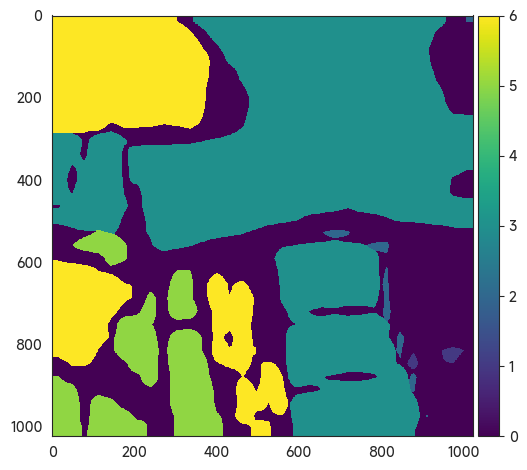

In [18]:
print("Mask shape:", mask.shape)
print(np.unique(mask))  # total 7 type
print(road_mask.shape,mask.shape)
io.imshow(mask)

In [19]:
mask[road_mask == 1] = 2# 2: road
mask

array([[6, 6, 6, ..., 2, 2, 2],
       [6, 6, 6, ..., 2, 2, 2],
       [6, 6, 6, ..., 2, 2, 2],
       ...,
       [5, 5, 5, ..., 0, 0, 0],
       [5, 5, 5, ..., 0, 0, 0],
       [5, 5, 5, ..., 0, 0, 0]], dtype=uint8)

In [20]:
mask_type_list = np.unique(mask)
print(mask_type_list)
print("本图片含有的分割类型")
df_label.loc[list(mask_type_list)] 

[0 1 2 3 5 6]
本图片含有的分割类型


,类别编号,类别名称（英文）,类别名称（中文）,说明
0,0,background,背景,通常为未分类区域
1,1,building,建筑,房屋、厂房等
2,2,road,道路,包括主干道、辅路等
3,3,water,水体,包括河流、湖泊等
5,5,forest,林地,森林、树木等
6,6,agriculture,耕地,农田、种植区域


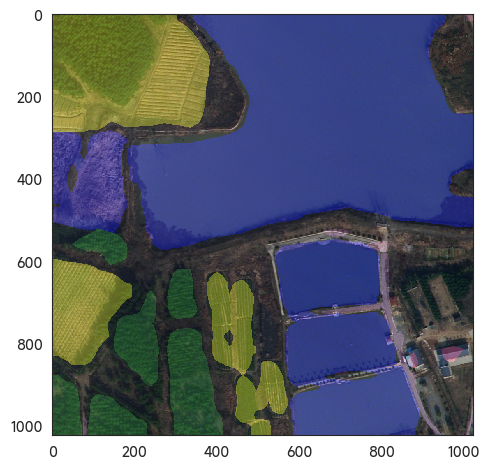

In [23]:
import numpy as np

# 构造类别编号到 RGB 的映射（索引即为类别编号）
id2color = np.array([
    [0, 0, 0],         # 0 - 背景
    [220, 20, 60],     # 1 - 建筑
    [128, 64, 128],    # 2 - 道路
    [0, 0, 255],       # 3 - 水体
    [210, 180, 140],   # 4 - 裸土
    [34, 139, 34],     # 5 - 林地
    [255, 255, 0]      # 6 - 耕地
], dtype=np.uint8)

from PIL import Image
import numpy as np

def overlay_mask_on_image(img: np.ndarray, mask: np.ndarray, colormap: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    """
    使用 PIL 实现透明叠加：将 mask 映射为彩色图，并叠加到原图上。

    参数:
        img (np.ndarray): 原始图像（RGB），shape = (H, W, 3)
        mask (np.ndarray): 分割掩码（0-6的类别编号），shape = (H, W)
        colormap (np.ndarray): 类别编号到 RGB 的映射表，shape = (N, 3)
        alpha (float): 叠加透明度（0-1）

    返回:
        np.ndarray: 叠加后的图像（uint8, RGB）
    """
    # 映射 mask -> RGB 彩色图
    mask_rgb = colormap[mask]  # shape = (H, W, 3)

    # 转为 float 做加权
    img_f = img.astype(np.float32)
    mask_f = mask_rgb.astype(np.float32)

    # 透明叠加
    blended = (1 - alpha) * img_f + alpha * mask_f
    blended = blended.clip(0, 255).astype(np.uint8)

    return blended


# 读取图像（确保是 RGB）
img = np.array(Image.open(test_image).convert("RGB"))

# 假设 mask 已是 0~6 的类别编号矩阵
# mask = ...

# 类别映射（前面定义的 id2color）
colored_overlay = overlay_mask_on_image(img, mask, id2color, alpha=0.3)

io.imshow(colored_overlay)


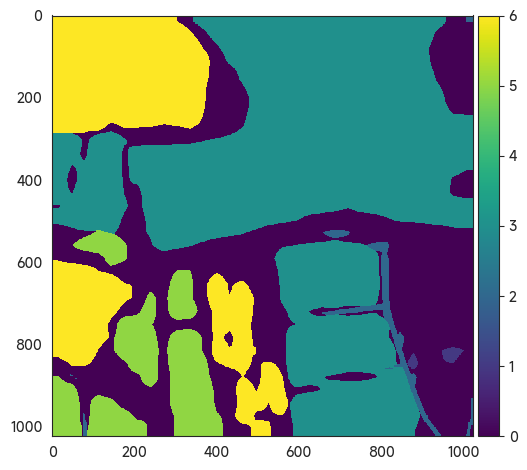

In [22]:
io.imshow(mask)